In [3]:
import tensorflow as tf
import os
import time
import datetime
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import skimage
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

INPUT_PATH = Path('/home/user1/Documents/andylui/DeepEnergy/pix2pix-floorplans-dataset/dev/Predictions/BEP_to_FSL')
img_1 = '0.png'

purple = np.array([255, 27, 255])
yellow = np.array([255, 255, 27])
blue = np.array([27, 27, 255])
red = np.array([255, 27, 27])
lightblue = np.array([27, 255, 255])
green = np.array([27, 255, 27])
orange = np.array([255, 155, 27])
white = np.array([255, 255, 255])
black = np.array([0, 0, 0])

rmFuncMap = {
    'bedroom': purple,
    'livingroom': yellow,
    'bathroom': blue,
    'kitchen': red,
    'storageroom': lightblue,
    'deckNporch': green,
    'corridor': orange,
    'background': white,
}

2023-03-21 14:09:11.538533: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


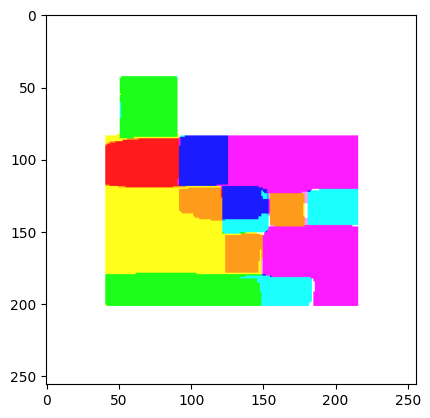

In [131]:
def replaceCloestColor(img, rmFuncMap): 
    img = img[...,:3]
    
    thresh = 30
    
    # Select room colors that are common in the image  
    vals, counts = np.unique(img.reshape(-1, 3), axis=0, return_counts=True)

    # form a dictionary of values/counts > threshold
    # out = dict(zip(map(tuple, vals[mask]), counts[mask]))
    # print(out)
    imgRmColor = set(map(tuple, vals[counts>thresh])) # form a set of values/counts > threshold
    # print('imgRmColor', imgRmColor)
    rmColorMap = set(map(tuple, rmFuncMap.values())) # form a set of room func color map
    
    rmColor = np.array(list(imgRmColor.intersection(rmColorMap))) # Select the resonable colors in the room func map only
    
    if len(rmColor) <= 1: 
        rmColor =  np.array(list(rmFuncMap.values()))
    rmColor =  np.array(list(rmFuncMap.values()))
    # print(rmColor)
    # Determine color differences (Use additional dimension)
    # Compute the shortest Euclidean distance within the color map 
    # print('img', img[:,:,None,:][0])
    # print('rmColor', rmColor)
    color_diffs = np.sum(((img[:,:,None,:]-rmColor).astype('uint32'))**2,axis=-1)**0.5
    # Get the indices of the closest value
    idx = np.argmin(color_diffs,axis=-1)
    
    # Extract closest value to assemble array
    img = rmColor[idx]
    
    # # Select room colors that are common in the image  
    # vals, counts = np.unique(img.reshape(-1, 3), axis=0, return_counts=True)
    # mask = counts>thresh

    # # form a dictionary of values/counts > threshold
    # out = dict(zip(map(tuple, vals[mask]), counts[mask]))
    # print(out)
    return img.astype('uint8')

def foo(img):
    img = replaceCloestColor(img, rmFuncMap)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # temp = cv2.drawContours(img, contours, -1, (0,255,0), 3)
    
    
    kernel = np.ones((10,10),np.uint8)
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    
    return closing

img = cv2.imread(str(INPUT_PATH / img_1))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = foo(img)
plt.imshow(img)
plt.show()


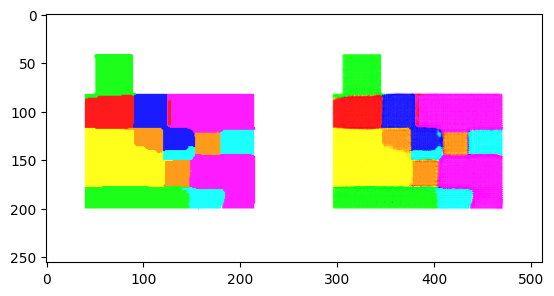

8


In [123]:
img = cv2.imread(str(INPUT_PATH / img_1))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

rmColor = np.array(list(rmFuncMap.values())).astype('uint8')

def intensity_median(mask, intensity_image):
    return np.median(intensity_image[mask], axis=0)

segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
label_image, num = label(segments_fz, return_num = True)

img[segments_fz == 0] = white

for i in range(1, num):
    seg_num = (segments_fz == i)
    seg_median  = np.median(img[seg_num], axis=0)
    color_diffs = np.sum((seg_median-rmColor)**2,axis=-1)
    
    # Get the indices of the closest value
    idx = np.argmin(color_diffs,axis=-1)
    
    img[seg_num] = rmColor[idx]
    # print(median_for_i)
# props = regionprops(segments_fz, img, extra_properties=(intensity_median,))
# label_to_median = {prop.label: prop.intensity_median for prop in props}

# img[(segments_fz != 14)] = orange
# img = replaceCloestColor(img, rmFuncMap)

img =  replaceCloestColor(img, rmFuncMap)
# print(img.dtype)
# print(a,b)
# print(np.sum((a-b)**2,axis=-1)**0.5)
# print(label_to_median)
# regionprops(label_image)
# for region in regionprops(label_image):
cnts = tuple()
for color in rmFuncMap.values(): 
    if color is not white: 
        mask = cv2.inRange(img.copy(), color, color)
        color_cnts, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # for cnt in cnts: 
        #     x,y,w,h = cv2.boundingRect(cnt)
        #     color_tuple = tuple(int(c) for c in color)
        #     # print(tuple(color_tuple))
            
        #     # x = (255, 255, 27)
        #     # print(type(x))
        #     # print(x == (255, 255, 27))
        #     cv2.rectangle(img, (x,y), (x+w, y+h), color_tuple,-1)
        cnts += color_cnts
# cnts = sorted(cnts, reverse=False, key=cv2.contourArea)    
# cnts = filter(lambda x: len(cv2.approxPolyDP(x, 0.1*cv2.arcLength(x, True), True)) == 4, cnts)
# for cnt in cnts:
#     x,y,w,h = cv2.boundingRect(cnt)
#     M = cv2.moments(cnt)
#     if M['m00'] != 0:
#         cx = int(M['m10']/M['m00'])
#         cy = int(M['m01']/M['m00'])
#         print(img)
#         if img[cx,cy] is not white: 
#             color = tuple(int(c) for c in img[cx,cy])
#             cv2.rectangle(img, (x,y), (x+w, y+h), color,-1)
# img = cv2.drawContours(img.copy(), cnts, -1, (0,255,0), 3)
# kernel = np.ones((5,5),np.uint8)
# img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
img_2 = cv2.imread(str(INPUT_PATH / img_1))
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)
img_combine = np.hstack((img, img_2))
plt.imshow(img_combine)
plt.show()



vals, counts = np.unique(img.reshape(-1, 3), axis=0, return_counts=True)
print(len(vals))

Felzenszwalb number of segments: 31
SLIC number of segments: 194
Quickshift number of segments: 351
Watershed number of segments: 256


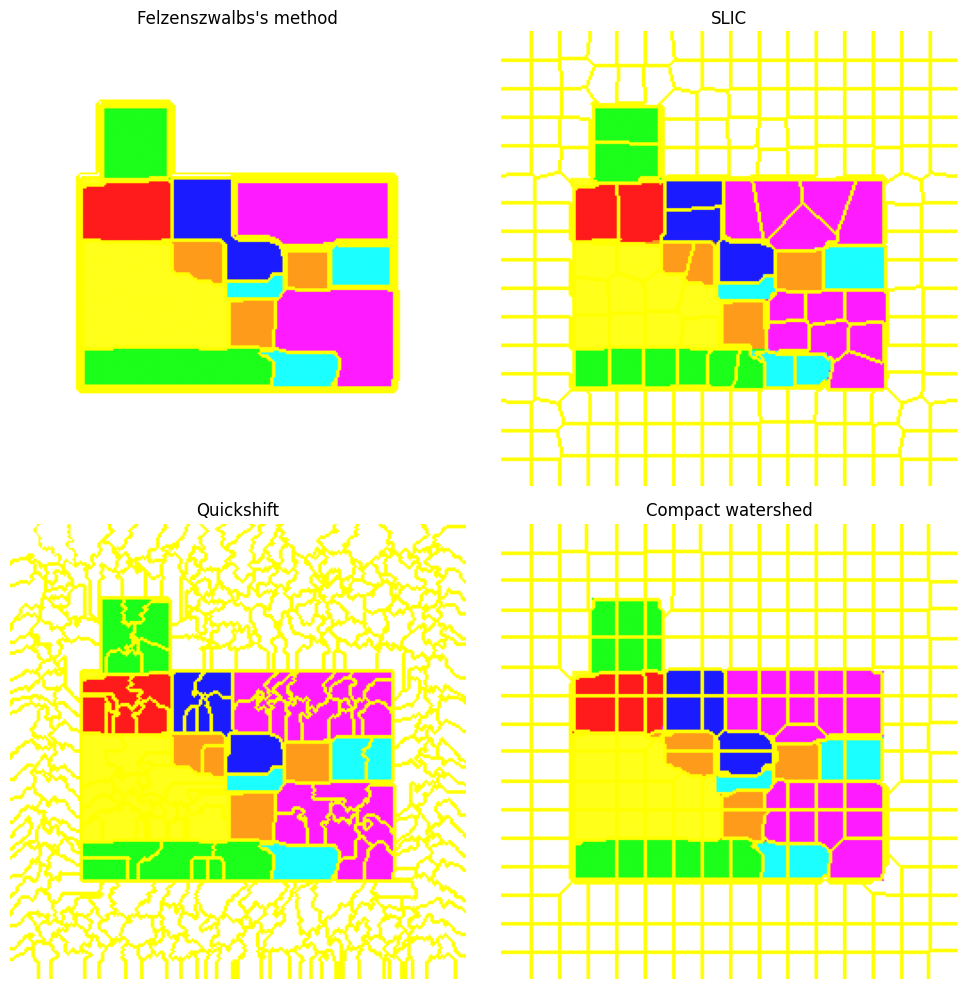

In [43]:


# img = cv2.imread(str(INPUT_PATH / img_1))
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=250, compactness=10, sigma=1,
                     start_label=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print(f'Felzenszwalb number of segments: {len(np.unique(segments_fz))}')
print(f'SLIC number of segments: {len(np.unique(segments_slic))}')
print(f'Quickshift number of segments: {len(np.unique(segments_quick))}')
print(f'Watershed number of segments: {len(np.unique(segments_watershed))}')

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

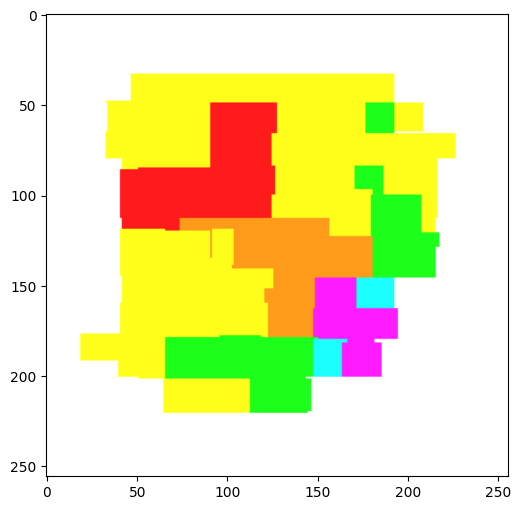

In [67]:


img = cv2.imread(str(INPUT_PATH / img_1))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# segments_fz = felzenszwalb(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), scale=100, sigma=0.5, min_size=50)
segments_fz = slic(img, n_segments=250, compactness=10, sigma=1,
                    start_label=1)
# cleared = clear_border(segments_fz)
label_image = label(segments_fz)
regionprops(label_image)
image_label_overlay = label2rgb(label_image, image=img, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img)
rmColor = np.array(list(rmFuncMap.values())).astype('uint8')
for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        seg = img[minc: maxc, minr: maxr]
        seg_median = np.median(seg.reshape(-1, 3), axis=0)


        color_diffs = np.sum((seg_median-rmColor)**2,axis=-1)
        
        # Get the indices of the closest value
        idx = np.argmin(color_diffs,axis=-1)
        
        # if (rmColor[idx] != white).any(): 
        #     print((rmColor[idx]))
        #     # Extract closest value to assemble array 
        img = cv2.rectangle(img, (minc, minr), (maxc, maxr), rmColor[idx].tolist(), -1)
        # rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                #   fill=False, edgecolor='red', linewidth=2)
        # ax.add_patch(rect)
        


plt.imshow(img)
plt.show()
# ax.set_axis_off()
# plt.tight_layout()
# plt.show()

{(255, 27, 27): 1428, (255, 155, 27): 64108}
rmColor [[255 155  27]
 [255  27  27]]
[[[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 ...

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]]
{(255, 155, 27): 65536}


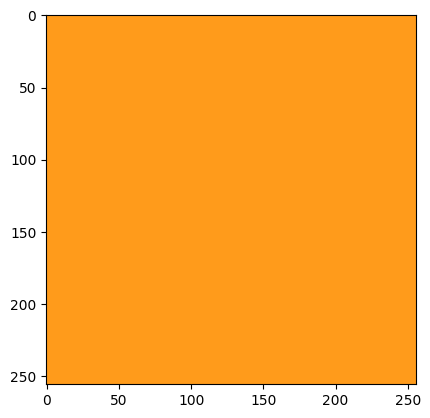

1


14 [255.  26.  25.]
[5.29010e+04 5.24450e+04 1.04885e+05 5.00000e+00 1.57325e+05 1.04429e+05
 1.66450e+04 1.05341e+05]



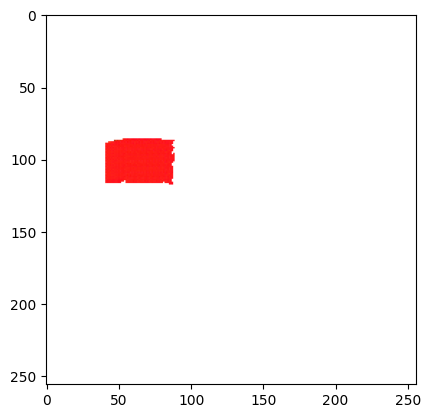

In [89]:
img = cv2.imread(str(INPUT_PATH / img_1))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)

i =14

rmColor = np.array(list(rmFuncMap.values())).astype('uint8')

seg_median  = np.median(img[segments_fz == i], axis=0)
print(i, seg_median)

color_diffs = np.sum((seg_median-rmColor)**2,axis=-1)
print(color_diffs)

print()

img[(segments_fz != i)] = white 

plt.imshow(img)
plt.show()